In [129]:
import sys
import numpy as np
from qick.spectrum import SpectrumSoc, DualChain
from qick.fft_helpers import *

import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

In [130]:
# Load bitstream with custom overlay
# soc = SpectrumSoc('./spectrum_v1_original.bit', no_tproc=True)
# soc = SpectrumSoc('/home/dmartin2/qick-tools_b_htest/spectrum_v1/pynq/spectrum_v1_original.bit', no_tproc=True)
soc = SpectrumSoc('/home/dmartin2/qick-tools_b_htest/spectrum_v1/pynq/spectrum_v1_250909_1/spectrum_v1.bit', no_tproc=True)

soccfg=soc
# Print information.
print(soccfg)


QICK running on ZCU111, software version 0.2.325

Firmware configuration (built Tue Sep  9 14:49:11 2025):

	Global clocks (MHz): tProcessor 0.000, RF reference 409.600

SPECTRUM configuration:


	Board: ZCU111
	Analysis 0:
		ADC: 224_0, fs = 4096.0 MHz, Decimation    = 2
		PFB: fs = 256.0 MHz, fc = 128.0 MHz, 16 channels


In [131]:
# # Start Debug Bridge Server if present
# try:
#     bridge = soc._get_block('debug_bridge_0')
#     bridge.start_xvc_server(bufferLen=4096, serverAddress="0.0.0.0", serverPort=2542, reconnect=True, verbose=True)

# except:
#     print('Debug blocks not found')


In [132]:
# ## Do not forget to stop the XVC server once you finish.
# bridge.stop_xvc_server()

In [133]:
#########################
### Define dual chain ###
#########################
chain = DualChain(soc,soc['analysis'][0],soc['synthesis'][0])

In [134]:
#Intial config
#PFB quantization
chain.analysis.qout(3)

10
256.0
F1 = 200.001, Y1 = -41.663


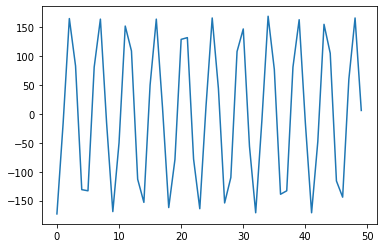

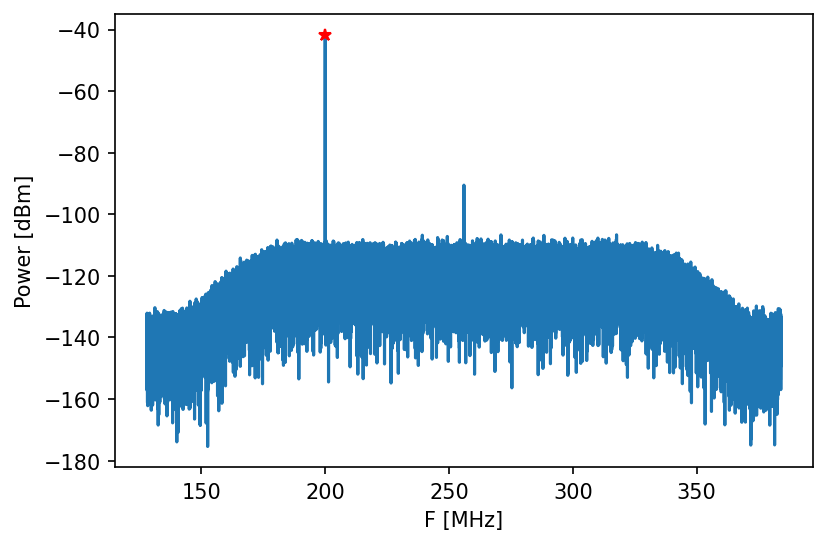

In [135]:
#################################
### Single Channel PFB output ###
#################################
fout = 200
chain.set_tone(fout)

# Compute channel center frequency.
pfb_channel = chain.analysis.freq2ch(fout)
print(pfb_channel)
FC = chain.analysis.ch2freq(pfb_channel)
print(FC)


# Get data.
[xi,xq] = chain.get_bin_pfb(fout)
x = xi + 1j*xq

plt.figure()
plt.plot(xi[:50])

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

Iteration K = 0; Freq: 1024.000000
Iteration K = 1; Freq: 1152.000000
Iteration K = 2; Freq: 1280.000000
Iteration K = 3; Freq: 1408.000000
Iteration K = 4; Freq: 1536.000000
Iteration K = 5; Freq: 1664.000000
Iteration K = 6; Freq: 1792.000000
Iteration K = 7; Freq: 1920.000000
Iteration K = 8; Freq: 0.000000
Iteration K = 9; Freq: 128.000000
Iteration K = 10; Freq: 256.000000
Iteration K = 11; Freq: 384.000000
Iteration K = 12; Freq: 512.000000
Iteration K = 13; Freq: 640.000000
Iteration K = 14; Freq: 768.000000
Iteration K = 15; Freq: 896.000000
Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


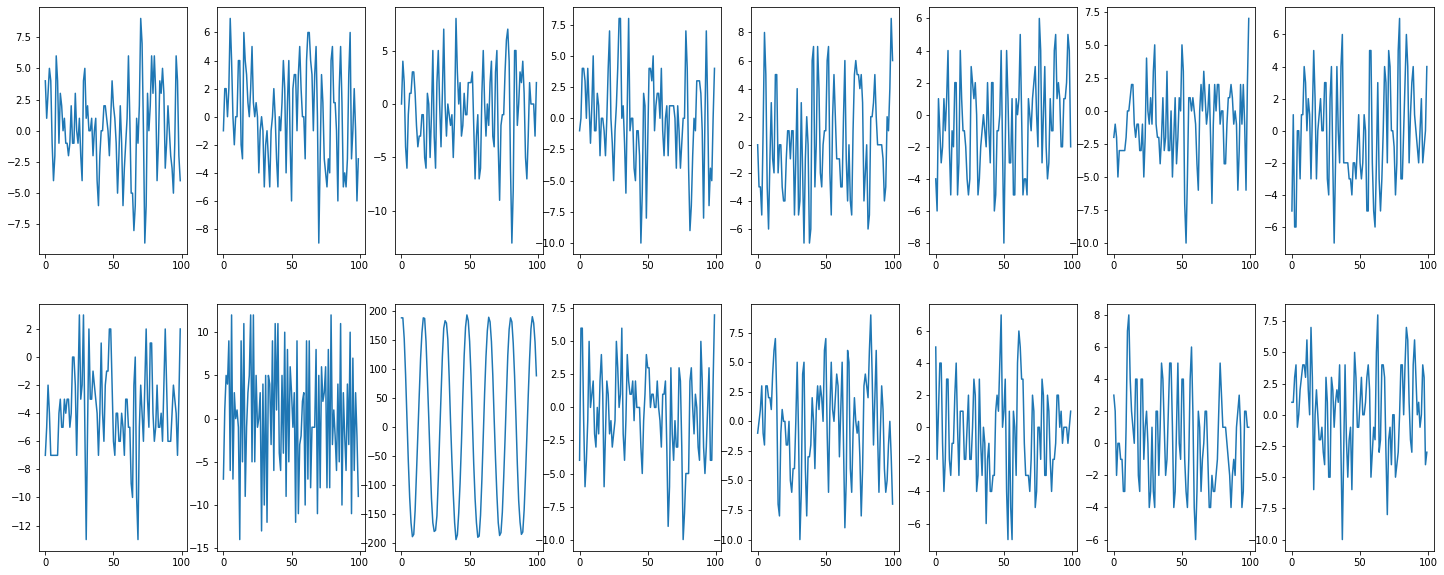

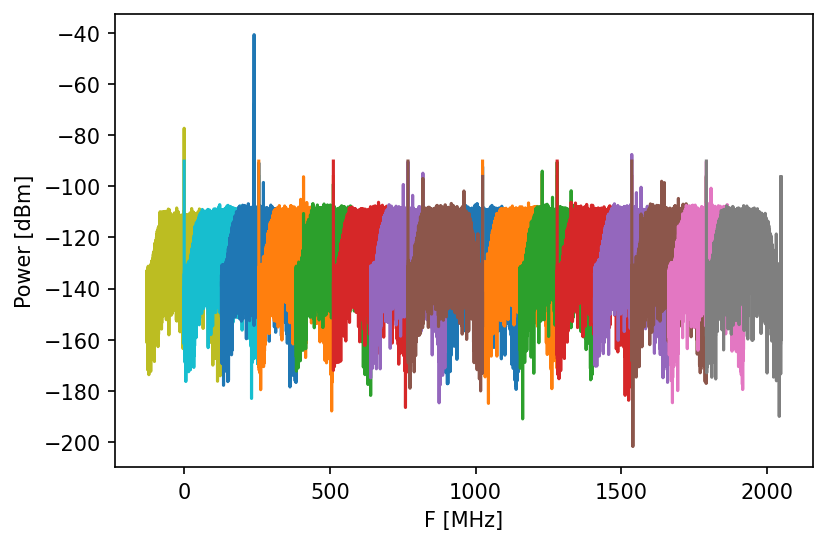

In [136]:
##########################################
### Channels Side-by-Side (PFB output) ###
##########################################

fout = 240
chain.set_tone(fout)


# Channels to plot.
K = np.arange(chain.nch)

# Frequency and amplitude vectors.
FF = []
AA = []

plt.figure(figsize=[25,10])

for KK in K:
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    print("Iteration K = %d; Freq: %f" % (KK, fck))  

    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    plt.subplot(2,8,KK+1)
    plt.plot(xi[:100])


plt.figure(dpi=150)

for KK in K:
    print("Iteration K = %d" %KK)  
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15

    # Spectrum.
    w = np.hanning(len(x))
    Aw = len(w)/np.sum(w)
    xw = Aw*x*w
    Y = fftshift(fft(xw)/len(xw))
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

F1 = 440.003, Y1 = -36.662
FFT Resolution: 15.625 kHz


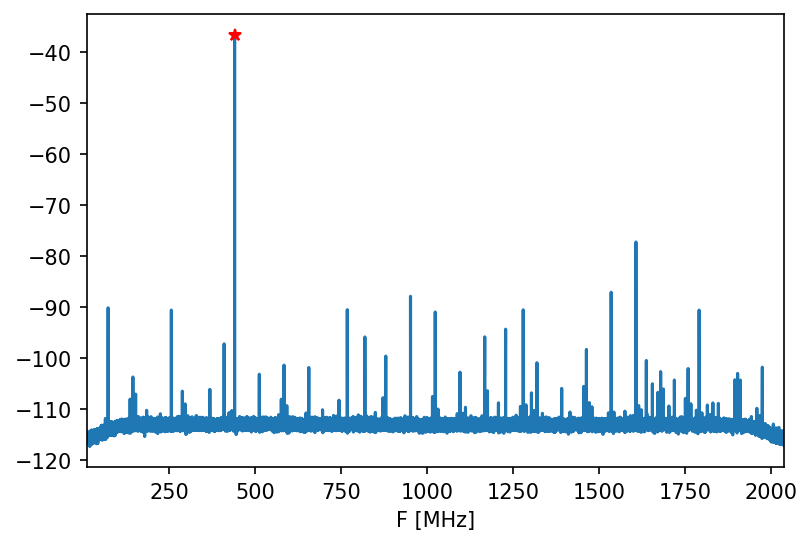

In [137]:
######################################
### Full Bandwidth ACC FULL output ###
######################################
fout = 440
chain.set_tone(fout,verbose=True)

# Number of averages.
N = 100

# Get data.
x = chain.get_data_acc(N)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by FFT length.
x = x/(soc.FFT_N)**2

# Spectrum.
Y = fftshift(x)
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.xlim([10,2040]);
#plt.ylim([-120,10]);

print('FFT Resolution: {} kHz'.format(1000*soc['analysis'][0]['fs_ch']/soc.FFT_N))

10
256.0
AnalysisChain: f = 270 MHz, fd = -754.0 MHz, k = 10
F1 = 256.200, Y1 = -47.779
FFT Resolution: 19.53125 Hz


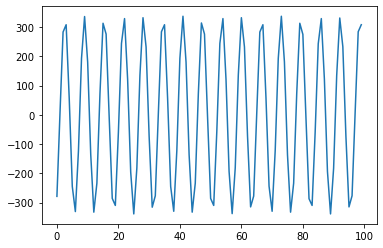

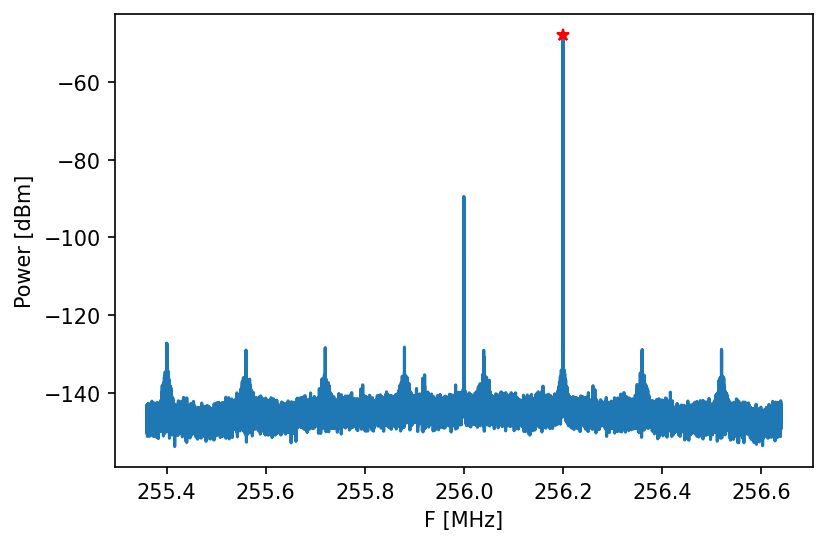

In [138]:
###############################
### Single Channel Zoom FFT ###
###############################
# Output frequency.
fout = 270
chain.set_tone(fout)

# Compute channel center frequency.
pfb_channel = chain.analysis.freq2ch(fout)
print(pfb_channel)
FC = chain.analysis.ch2freq(pfb_channel)
print(FC)

# DEBUG
# soc.axis_ddscic_v3_0.ddsfreq(f=10e6)
# soc.axis_ddscic_v3_0.outsel(data="dds", cic="no")
# [xi,xq] = chain.get_bin_pfb(fout, verbose=True)
# plt.figure()
# plt.plot(xi[:100])

# DEBUG
# soc.axis_ddscic_v3_0.outsel(data="input", cic="no")
# [xi,xq] = chain.get_bin_pfb(fout, verbose=True)
# plt.figure()
# plt.plot(xi[:100])


# DDS + CIC configuration.
D=200
soc.axis_ddscic_v3_0.outsel(data="product", cic="yes")
soc.axis_ddscic_v3_0.decimation(D)
soc.axis_ddscic_v3_0.ddsfreq(f=14e6-200e3)
soc.axis_ddscic_v3_0.set_qprod(14) # quantization range for product 0-16
[xi,xq] = chain.get_bin_pfb(fout, verbose=True)
plt.figure()
plt.plot(xi[:100])


# Get data.
#x = soc.acc_zoom.single_shot(10)
x = soc.axis_accumulator_1.single_shot(10)

# Sampling frequency.
fs = chain.analysis.dict['chain']['fs_ch']/soc.axis_ddscic_v3_0.get_decimation()
F = np.linspace(-fs/2,fs/2,len(Y))


# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by window gain.
#x = x*(soc.axis_wxfft_65536_0.Aw)**2*(2**16)**2

# Scale by FFT length.
x = x/(soc.axis_accumulator_1.FFT_N)**2

# Spectrum.
Y = x
F = np.linspace(-fs/2,fs/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

#print('FFT Resolution: {} Hz'.format(1000*1000*fs/soc.acc_zoom.FFT_N))
print('FFT Resolution: {} Hz'.format(1000*1000*fs/soc.axis_accumulator_1.FFT_N))

In [139]:
65536*1/fs

51200.0

In [140]:
soc.ip_dict

{'axis_constant_iq_0': {'type': 'user.org:user:axis_constant_iq:1.0',
  'mem_id': 's_axi',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'B': '16',
   'N': '8',
   'Component_Name': 'd_1_axis_constant_iq_0_0',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_BASEADDR': '0xA0004000',
   'C_HIGHADDR': '0xA0004FFF',
   'TDATA_NUM_BYTES': '32',
   'TDEST_WIDTH': '0',
   'TID_WIDTH': '0',
   'TUSER_WIDTH': '0',
   'HAS_TREADY': '0',
   'HAS_TSTRB': '0',
   'HAS_TKEEP': '0',
   'HAS_TLAST': '0',
   'FREQ_HZ': '384000000',
   'PHASE': '0.0',
   'CLK_DOMAIN': 'd_1_usp_rf_data_converter_0_0_clk_dac1',
   'LAYERED_METADATA': 'undef',
   'INSERT_VIP': '0',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'ID_WIDTH': '0',
   'ADDR_WIDTH': '6',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_WIDTH': '0',
   'RUSER_WIDTH': '0',
   'BUSER_WIDTH': '0',
   'READ_WRITE_MODE': 'READ_WRITE',
   'HAS_BURST': '0',
   'HAS_LOCK': '0',
   'HAS_PROT': '1',
   'HAS_CACHE': '0',
 

In [141]:
chain.synthesis.dict

{'chain': {'type': 'synthesis', 'iq': 'axis_constant_iq_0', 'dac': '13'},
 'mixer': {'mode': 'complex2real',
  'type': 'fine',
  'evnt_src': 'immediate',
  'freq': 270.0},
 'nqz': 1}

In [142]:
soc.set_iq?

Signature: soc.set_iq(ch, f, i, q, ro_ch=None, phase_reset=True)
Docstring:
Set frequency, I, and Q for a constant-IQ output.

Parameters
----------
ch : int
    DAC channel (index in 'gens' list)
f : float
    frequency (in MHz)
i : float
    I value (in range -1 to 1)
q : float
    Q value (in range -1 to 1)
ro_ch : int
    readout channel (index in 'readouts' list) for frequency matching
    use None if you don't want freq to be rounded to a valid readout frequency
phase_reset : bool
    if this changes the frequency, also reset the phase (so if we go to freq=0, we end up on the real axis)
File:      /home/xilinx/jupyter_notebooks/qick/qick_lib/qick/qick.py
Type:      method


In [143]:
soc.gens

[]

In [144]:
chain.set_tone(fout,verbose=True)

In [145]:
chain.analysis.set_mixer_frequency(fout)

RuntimeError: Mixer not active

In [ ]:
chain.analysis.get_mixer_frequency()